<a href="https://colab.research.google.com/github/nicolas1805961/Deep-learning/blob/main/Projet_dlim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile
import shutil
import glob
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from math import ceil, floor

In [ ]:
shutil.rmtree('/content/metadata', ignore_errors=True)
shutil.rmtree('/content/train', ignore_errors=True)
shutil.rmtree('/content/validation', ignore_errors=True)

In [2]:
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/wider_face_split.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/metadata/')
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/WIDER_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/train/')
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/WIDER_val.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/validation/')

In [132]:
height_features = 19
width_features = 19
height, width = 256, 256
anchors = np.array([[20., 20.], [40., 40.]]).reshape((-1, 2)) / height
ignore_threshold = 0.5

In [4]:
def get_right_images(filepath_train, filepath_val, top_path_train, top_path_val):
  map_filename_bbx = {}
  for filepath, top_path in zip([filepath_train, filepath_val], [top_path_train, top_path_val]):
    with open(filepath) as file:
      lines = file.read().splitlines()
      file_name_line_number = 0
      face_line_number = 0
      while file_name_line_number < len(lines):
        number_of_faces = int(lines[file_name_line_number + 1])
        if number_of_faces is 0:
          number_of_faces += 1
        values = []
        key = lines[file_name_line_number]
        while face_line_number < number_of_faces:
          fields = lines[file_name_line_number + 2 + face_line_number].split()
          fields = list(map(int, fields))
          if fields[4] is not 0 or fields[5] is not 0 or fields[6] is not 0 or fields[7] is not 0 or fields[8] is not 0 or fields[9] is not 0:
            face_line_number += 1
            values = []
            break
          value = np.array([x for x in fields[:4]])
          if len(value) > 0:
            values.append(value)
          face_line_number += 1
        if values:
          map_filename_bbx[top_path + key] = values
        file_name_line_number += number_of_faces + 2
        face_line_number = 0
  return map_filename_bbx

In [5]:
def get_aspect_ratio(right_images):
  aspect_ratio_list = []
  for key in list(right_images):
    image_size = Image.open(key).size
    if image_size[0] < image_size[1]:
      del right_images[key]
      continue
    aspect_ratio_list.append(float(image_size[0]) / float(image_size[1]))
  print(256 / np.median(aspect_ratio_list))
  print(256 / np.array(aspect_ratio_list).mean())
  return right_images

In [ ]:
def normalize_images(X_train, X_val, X_test):
  means = X_train.mean(axis=(0,1,2), keepdims=True)
  stds = X_train.std(axis=(0,1,2), keepdims=True)
  X_train = (X_train - means) / stds
  X_val = (X_val - means) / stds
  X_test = (X_test - means) / stds
  return X_train, X_val, X_test

In [109]:
def get_iou(bbx1, bbx2):
  x_left = np.maximum(bbx1[..., 0], bbx2[..., 0])
  y_top = np.maximum(bbx1[..., 1], bbx2[..., 1])
  x_right = np.minimum(bbx1[..., 0] + bbx1[..., 2], bbx2[..., 0] + bbx2[..., 2])
  y_bottom = np.minimum(bbx1[..., 1] + bbx1[..., 3], bbx2[..., 1] + bbx2[..., 3])

  intersection_area = (np.maximum(np.zeros(x_right.shape), x_right - x_left) * np.maximum(np.zeros(y_bottom.shape), y_bottom - y_top)).astype(np.float32)

  bbx1_area = bbx1[..., 2] * bbx1[..., 3]
  bbx2_area = bbx2[..., 2] * bbx2[..., 3]

  iou = intersection_area / (bbx1_area + bbx2_area - intersection_area)
  return iou

In [130]:
def get_iou_not_same_shape(boxes, predictions):

    boxes = tf.expand_dims(boxes, 1)
    predictions = tf.expand_dims(predictions, 2)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(predictions), tf.shape(boxes))
    boxes = tf.broadcast_to(boxes, new_shape)
    predictions = tf.broadcast_to(predictions, new_shape)

    x_box = boxes[..., 0]
    y_box = boxes[..., 1]
    w_box = boxes[..., 2]
    h_box = boxes[..., 3]

    x_pred = predictions[..., 0]
    y_pred = predictions[..., 1]
    w_pred = predictions[..., 2]
    h_pred = predictions[..., 3]

    x_left = tf.math.maximum(x_box, x_pred)
    y_top = tf.math.maximum(y_box, y_pred)
    x_right = tf.math.minimum(x_box + w_box, x_pred + w_pred)
    y_bottom = tf.math.minimum(y_box + h_box, y_pred + h_pred)

    intersection_area = tf.math.maximum(0, x_right - x_left) * tf.math.maximum(0, y_bottom - y_top)

    boxes_area = w_box * h_box
    predictions_area = w_pred * h_pred

    union = boxes_area + predictions_area - intersection_area

    iou = intersection_area / union

    return iou

In [137]:
class Preprocessing:

  def __init__(self, height, width, width_features, height_features, anchors, ignore_threshold):
    self.height = height
    self.width = width
    self.width_features = width_features
    self.height_features = height_features
    self.anchors = anchors
    self.height_size = height / height_features
    self.width_size = width / width_features
    self.ignore_threshold = ignore_threshold

  def set_labels(self, bbx_list):
    Y = np.zeros((len(bbx_list), self.height_features, self.width_features, len(self.anchors), 5))
    for image_index, bbxs in enumerate(bbx_list):
      for i in range(0, self.height_features):
        cell_row_min = i * self.height_size
        cell_row_max = min((i + 1) * self.height_size, self.height)
        for j in range(0, self.width_features):
          cell_col_min = j * self.width_size
          cell_col_max = min((j + 1) * self.width_size, self.width)
          for t in range(bbxs.shape[0]):
            bbx = bbxs[t]
            object_midpoint = np.array([bbx[0] + (bbx[2] / 2), bbx[1] + (bbx[3] / 2)])
            if cell_row_min < object_midpoint[1] < cell_row_max and cell_col_min < object_midpoint[0] < cell_col_max:
              anchors = np.repeat(self.anchors, 2, axis=1)
              anchors[:, 2] = anchors[:, 2] * self.width
              anchors[:, 3] = anchors[:, 3] * self.height
              anchors[:, 0] = np.maximum(np.zeros((anchors.shape[0],)), np.repeat(object_midpoint[0], anchors.shape[0], axis=0) - (anchors[:, 2] / 2))
              anchors[:, 1] = np.maximum(np.zeros((anchors.shape[0],)), np.repeat(object_midpoint[1], anchors.shape[0], axis=0) - (anchors[:, 3] / 2))
              object_box = np.repeat(bbx.reshape((1, 4)), anchors.shape[0], axis=0)
              iou = get_iou(object_box.astype(np.float32), anchors.astype(np.float32))
              index = np.argmax(iou)
              y = (object_midpoint[1] - cell_row_min) / (cell_row_max - cell_row_min)
              x = (object_midpoint[0] - cell_col_min) / (cell_col_max - cell_col_min)
              w = bbx[2] / self.width
              h = bbx[3] / self.height
              Y[image_index, i, j, index, :] = np.array([1, x, y, w, h])
    return Y

  def get_images_and_labels(self, right_images):
    image_list = []
    bbx_list = []
    for item in right_images.items():
      image = Image.open(item[0])

      image = np.array(image)
      ratio = min(self.height / image.shape[1], self.width / image.shape[0])
      new_shape = (round(image.shape[1] * ratio), round(image.shape[0] * ratio))
      image = cv.resize(image, new_shape, interpolation=cv.INTER_CUBIC)

      padding_amount_rows = (self.height - image.shape[0]) / 2
      padding_amount_cols = (self.width - image.shape[1]) / 2

      values = []
      for bbx in item[1]:
        new_bbx = bbx * ratio
        new_bbx[0] += padding_amount_cols
        new_bbx[1] += padding_amount_rows
        values.append(new_bbx)
      
      bbxs = np.stack(values)

      image = np.pad(image, ((floor(padding_amount_rows), ceil(padding_amount_rows)), (floor(padding_amount_cols), ceil(padding_amount_cols)), (0, 0)))
      image_list.append(image)
      bbx_list.append(bbxs)
        
    images = np.stack(image_list)
    return images, bbx_list

  def get_loss(self, label, boxes, prediction):
    grid = tf.meshgrid(tf.range(self.width_features, dtype=tf.float32), tf.range(self.height_features, dtype=tf.float32))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
    grid = tf.tile(grid, (1, 1, self.anchors.shape[0], 1))

    bx_by = tf.math.sigmoid(prediction[..., 1:3]) + grid
    bo = tf.math.sigmoid(prediction[..., 0])
    bw_bh = tf.exp(prediction[..., 3:]) * self.anchors
    bx_by = bx_by - bw_bh / 2
    abs_predictions = tf.reshape(tf.concat([bx_by, bw_bh], axis=-1), (label.shape[0], -1, 4))

    ious = get_iou_not_same_shape(boxes, abs_predictions)
    best_iou = tf.reshape(tf.reduce_max(ious, axis=-1), (label.shape[0], self.height_features, self.width_features, len(self.anchors)))
    noobj_mask = tf.cast(best_iou < self.ignore_threshold, tf.float32) * (1 - label[..., 0])

    print(noobj_mask.shape)
    
    return best_iou

In [38]:
from sklearn.model_selection import train_test_split

right_images = get_right_images('/content/metadata/wider_face_split/wider_face_train_bbx_gt.txt', '/content/metadata/wider_face_split/wider_face_val_bbx_gt.txt', '/content/data/train/WIDER_train/images/', '/content/data/validation/WIDER_val/images/')
print(len(right_images))
right_images = get_aspect_ratio(right_images)
print(len(right_images))

4771
174.5
175.58177913137203
2727


In [116]:
def bbx_list_to_array(bbx_list):
  bbx_list = sorted(bbx_list, key=lambda x: len(x))
  nb = len(bbx_list[-1])
  for i in range(len(bbx_list)):
    bbx_list[i] = np.pad(bbx_list[i], ((0, nb - len(bbx_list[i])), (0, 0)))
  bbxs = np.stack(bbx_list).astype(np.float32)
  return bbxs

In [138]:
preprocessing = Preprocessing(height, width, width_features, height_features, anchors, ignore_threshold)
images, bbx_list = preprocessing.get_images_and_labels(right_images)
Y = preprocessing.set_labels(bbx_list)
bbxs = bbx_list_to_array(bbx_list)
print(bbxs.shape)

(2727, 180, 4)


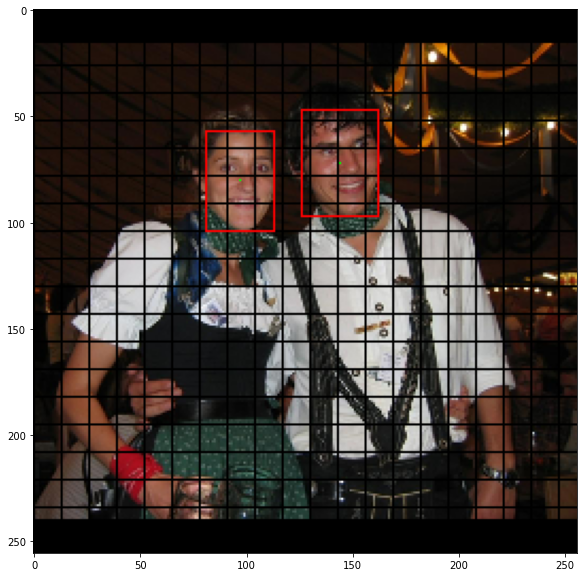

In [141]:
index = np.random.randint(0, Y.shape[0])
width_size = width / width_features
height_size = height / height_features
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
test_image = images[index]
test_image[::int(height_size), :, :] = 0
test_image[:, ::int(width_size), :] = 0
Y_test = Y[index]
for i in range(Y_test.shape[0]):
  for j in range(Y_test.shape[1]):
    for t in range(Y_test.shape[2]):
      if Y_test[i, j, t, :].any():
        bbox = Y_test[i, j, t, 1:]
        w = int(bbox[2] * width)
        h = int(bbox[3] * height)
        object_midpoint_x = bbox[0] * width_size + (j * width_size)
        object_midpoint_y = bbox[1] * height_size + (i * height_size)
        test_image[int(object_midpoint_y), int(object_midpoint_x), :] = np.array([0, 255, 0])
        y = int(max(0, object_midpoint_y - (h / 2)))
        x = int(max(0, object_midpoint_x - (w / 2)))
        test_image = cv.rectangle(test_image, (x, y), (x + w, y + h), (255, 0, 0), 1)
ax.imshow(test_image)

In [135]:
y_hat = np.random.rand(32, 19, 19, 2, 5).astype(np.float32)
y = np.random.rand(32, 19, 19, 2, 5).astype(np.float32)
bbxs_test = bbxs[:32]

ious = preprocessing.get_loss(y, bbxs_test, y_hat)

(32, 19, 19, 2)


In [ ]:
def resnet_block(inputs, filters, reduce):
  shortcut = 0
  if reduce:
    x = layers.Conv2D(filters, 3, stride=2, padding="same")(inputs)
    shortcut = layers.Conv2D(filters, 3, stride=2, padding="same")(inputs)
    shortcut = layers.BatchNormalization()(shortcut)
  else:
    x = layers.Conv2D(filters, 3, stride=1, padding="same")(inputs)
    shortcut = inputs

  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.1)(x)

  x = layers.Conv2D(filters, 3, stride=1, padding="same")(x)
  x = layers.BatchNormalization()(x)

  x = layers.add([x, inputs])

  x = layers.LeakyReLU(alpha=0.1)(x)

  return x

In [ ]:
from tensorflow.keras.layers import concatenate

def get_model():

    inputs = keras.Input((176, 256, 3))

    x = resnet_block(inputs, 16, True)
    x = resnet_block(x, 16, False)

    x = resnet_block(x, 32, True)
    x = resnet_block(x, 32, False)

    x = resnet_block(x, 64, True)
    x = resnet_block(x, 64, False)
    x = resnet_block(x, 64, False)

    x = resnet_block(x, 128, True)
    x = resnet_block(x, 128, False)
    x = resnet_block(x, 128, False)

    model = keras.Model(inputs, outputs)
    return model


keras.backend.clear_session()

model = get_model()
model.summary()

In [ ]:
'''def get_images_and_labels(directory, right_images):
  image_list = []
  label_list = []
  filepath_list = []
  for subdir, dirs, files in os.walk(directory):
    for file in files:
      filepath = os.path.join(subdir, file)
      filepath_name = '/'.join(filepath.split('/')[4:])
      image = Image.open(filepath)

      image = np.array(image)
      ratio = min(256 / image.shape[1], 176 / image.shape[0])
      new_shape = (round(image.shape[1] * ratio), round(image.shape[0] * ratio))
      image = cv.resize(image, new_shape, interpolation=cv.INTER_CUBIC)

      label = np.zeros(image.shape[:-1], dtype=np.uint8)

      for bb in right_images[filepath_name]:
        label[round(bb[1] * ratio):round((bb[1] + bb[3]) * ratio), round(bb[0] * ratio):round((bb[0] + bb[2]) * ratio)] = 1

      padding_amount_rows = (176 - image.shape[0]) / 2
      padding_amount_cols = (256 - image.shape[1]) / 2

      image = np.pad(image, ((floor(padding_amount_rows), ceil(padding_amount_rows)), (floor(padding_amount_cols), ceil(padding_amount_cols)), (0, 0)))
      label = np.pad(label, ((floor(padding_amount_rows), ceil(padding_amount_rows)), (floor(padding_amount_cols), ceil(padding_amount_cols))))
      image_list.append(image)
      label_list.append(label)
      filepath_list.append(filepath_name)
      
  images = np.stack(image_list)
  labels = np.stack(label_list)
  return images, labels, filepath_list, right_images'''

In [ ]:
'''X, Y, filepaths, right_images = get_images_and_labels('data', right_images)
print(len(filepaths))
print(X.shape)
print(Y.shape)
print(len(right_images))'''

2727
(2727, 176, 256, 3)
(2727, 176, 256)
2727


In [ ]:
test_size = 20 / X.shape[0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

19--Couple/19_Couple_Couple_19_476.jpg
18--Concerts/18_Concerts_Concerts_18_998.jpg
45--Balloonist/45_Balloonist_Balloonist_45_33.jpg
29--Students_Schoolkids/29_Students_Schoolkids_Students_Schoolkids_29_665.jpg
23--Shoppers/23_Shoppers_Shoppers_23_639.jpg


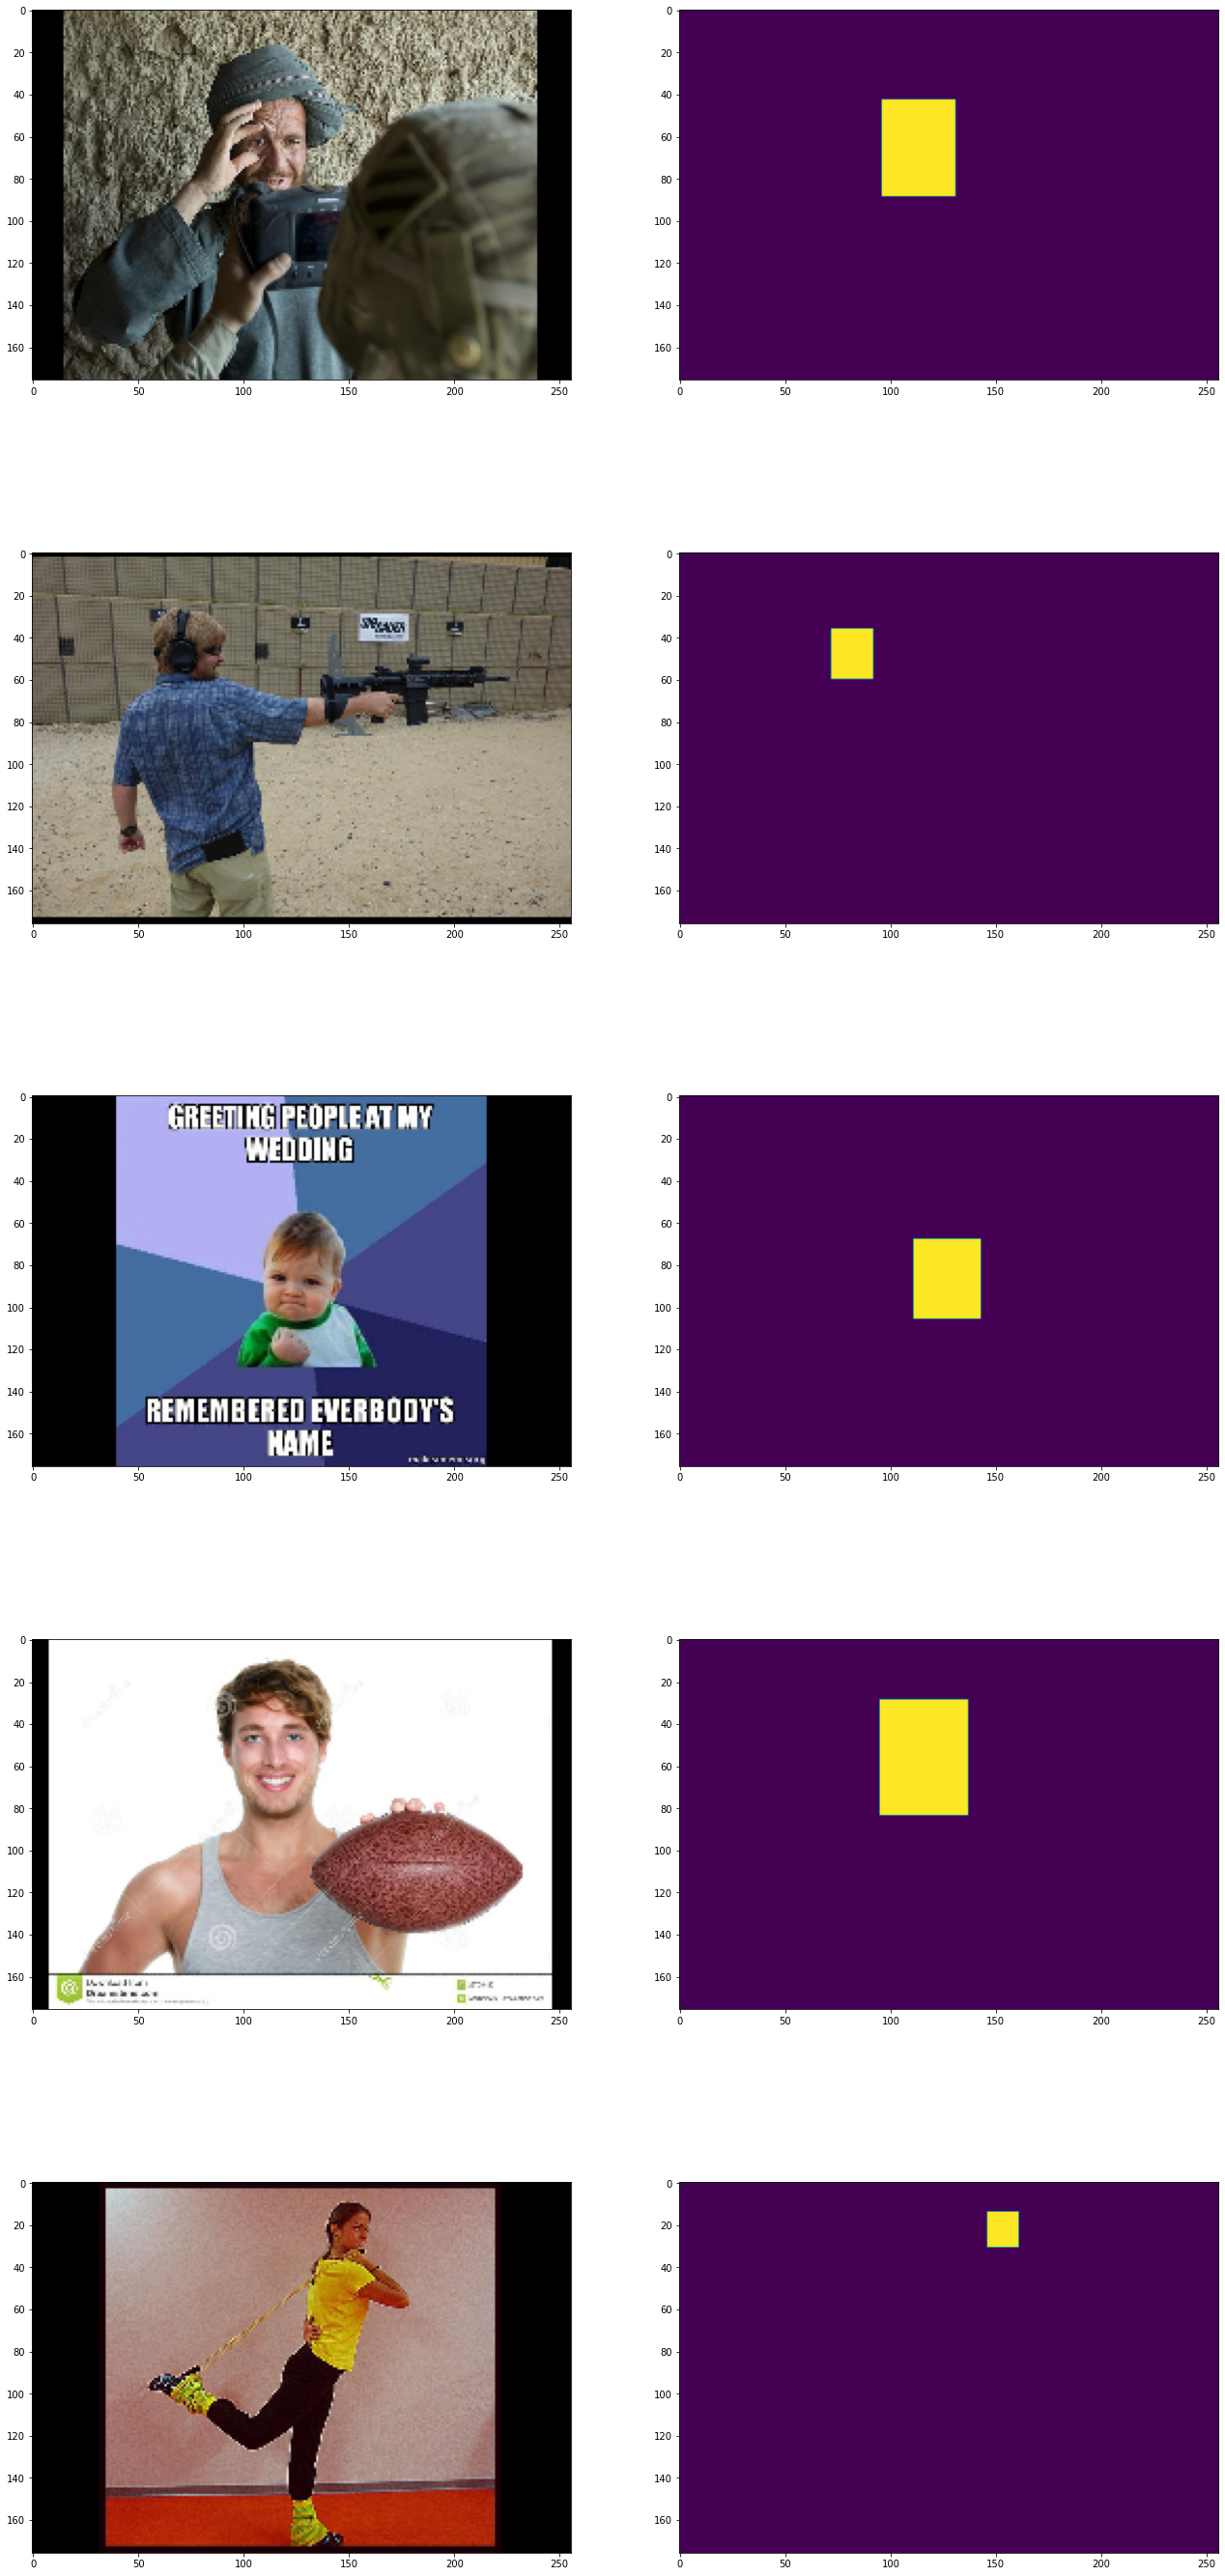

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(22, 50))
indices = np.random.randint(0, X_train.shape[0], 5)
for plot_index, image_index in zip(range(5), indices):
  print(filepath_train[image_index])
  ax[plot_index, 0].imshow(X_train[image_index])
  ax[plot_index, 1].imshow(Y_train[image_index])

In [ ]:
X_train, X_val, X_test = normalize_images(X_train, X_val, X_test)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2165, 176, 256, 3)
(542, 176, 256, 3)
(20, 176, 256, 3)


In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle


class Data_generator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, X, Y):
        self.batch_size = batch_size
        self.X = X
        self.Y = Y
        self.indices = np.arange(X.shape[0])

    def on_train_begin(self):
      np.random.shuffle(self.indices)

    def on_epoch_end(self):
      np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.Y) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.X[inds]
        batch_y = self.Y[inds]
        return batch_x, batch_y

# Instantiate data Sequences for each split
batch_size = 16
train_gen = Data_generator(batch_size, X_train, Y_train)
val_gen = Data_generator(batch_size, X_val, Y_val)

In [ ]:
def conv_bloc(filters, inputs):
  x = layers.Conv2D(filters, 3, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(filters, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  return x

In [ ]:
from tensorflow.keras.layers import concatenate

def get_model():

    inputs = keras.Input((176, 256, 3))

    layer_list = []
    filters_left = [16]
    filters_right = [16, 8]

    x = conv_bloc(filters_right[-1], inputs)
    layer_list.append(tf.identity(x))
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    for filters in filters_left:
        x = conv_bloc(filters, x)
        layer_list.append(tf.identity(x))
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    print(x.shape)
    x = conv_bloc(filters_left[-1] * 2, x)

    for j in range(0, len(filters_left) + 1):
      print(layer_list[j].shape)

    for i, filters in zip(range(len(filters_left), -1, -1), filters_right):
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.UpSampling2D(2)(x)
        x = concatenate([x, layer_list[i]])
        x = conv_bloc(filters, x)

    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model


keras.backend.clear_session()

model = get_model()
model.summary()

(None, 44, 64, 16)
(None, 176, 256, 8)
(None, 88, 128, 16)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 176, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 176, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 176, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 176, 256, 8)  0           batch_normalization[0][0]        
____________________________

In [ ]:
from keras import optimizers

adam = optimizers.Adam()

model.compile(optimizer=adam, metrics=['accuracy'], loss="binary_crossentropy")

# Train the model, doing validation at the end of each epoch.
model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
135/135 [==============================] - 8s 63ms/step - loss: 0.3054 - accuracy: 0.9044 - val_loss: 0.3085 - val_accuracy: 0.9226
Epoch 2/10
135/135 [==============================] - 8s 61ms/step - loss: 0.1571 - accuracy: 0.9453 - val_loss: 0.2161 - val_accuracy: 0.9198
Epoch 3/10
135/135 [==============================] - 8s 61ms/step - loss: 0.1387 - accuracy: 0.9505 - val_loss: 0.1995 - val_accuracy: 0.9275
Epoch 4/10
135/135 [==============================] - 8s 61ms/step - loss: 0.1266 - accuracy: 0.9546 - val_loss: 0.1460 - val_accuracy: 0.9470
Epoch 5/10
135/135 [==============================] - 8s 62ms/step - loss: 0.1189 - accuracy: 0.9579 - val_loss: 0.1232 - val_accuracy: 0.9566
Epoch 6/10
135/135 [==============================] - 8s 62ms/step - loss: 0.1133 - accuracy: 0.9598 - val_loss: 0.1164 - val_accuracy: 0.9603
Epoch 7/10
135/135 [==============================] - 8s 63ms/step - loss: 0.1103 - accuracy: 0.9609 - val_loss: 0.1179 - val_accuracy: 0.9576

In [ ]:
model.save("/content/drive/MyDrive/projet_dlim/model_dlim")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/projet_dlim/model_dlim/assets


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/projet_dlim/model_dlim')

In [ ]:
predictions = model.predict(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

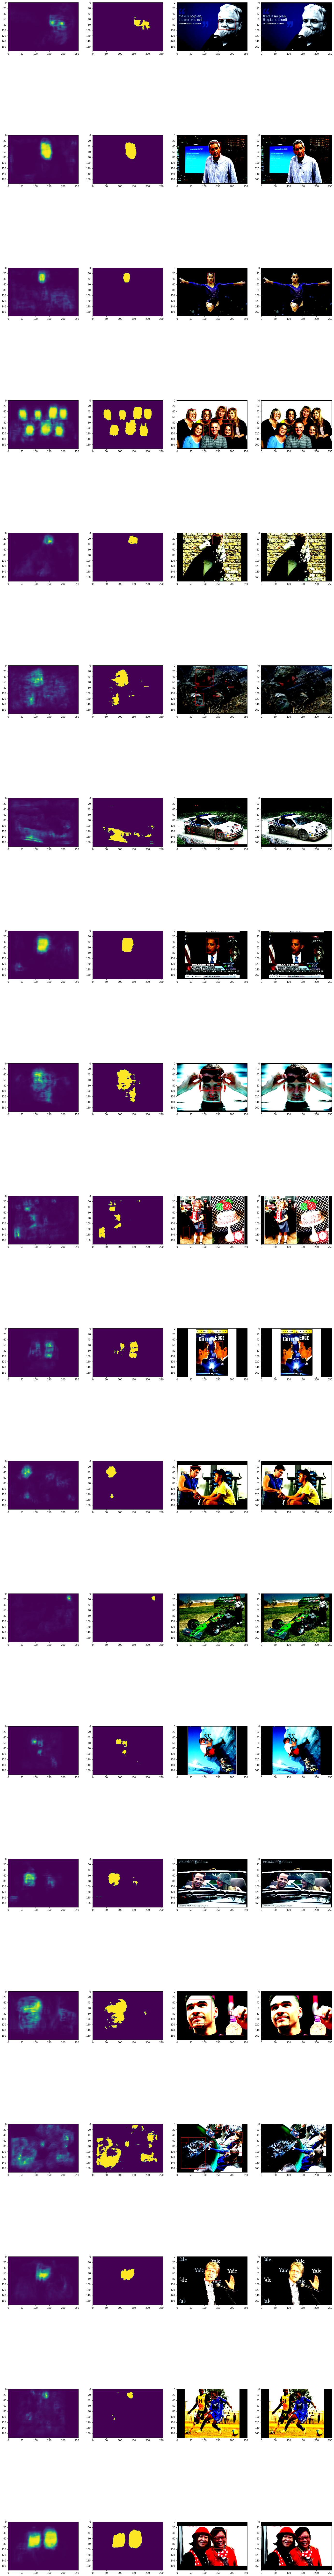

In [ ]:
fig, ax = plt.subplots(20, 3, figsize=(24, 200))
for i in range(20):
  image_normalized = cv.normalize(predictions[i], -1, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
  ret, thresh = cv.threshold(image_normalized,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
  retval, labels, stats, centroids = cv.connectedComponentsWithStats(thresh, 8, cv.CV_32S)
  bb_image = X_test[i].copy()
  for j in range(1, stats.shape[0]):
    bbox = stats[j]
    bb_image = cv.rectangle(bb_image, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (255, 0, 0), 1)
  ax[i, 0].imshow(predictions[i][..., 0])
  ax[i, 1].imshow(thresh)
  ax[i, 2].imshow(bb_image)